In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Predicting Diabetes patient risk to develop Heart Failure with Med-BERT

In [2]:
### Required Packages
from termcolor import colored
import math
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import numpy as np
from datetime import datetime
import pickle as pkl
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim
import tqdm
import time
import transformers
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline
use_cuda = torch.cuda.is_available()
import transformers
from transformers import BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from tqdm import tqdm



#### Load Data from pickled list

The pickled list is a list of lists where each sublist represent a patient record that looks like
[pt_id,label, seq_list , segment_list ]
where
    Label: 1: pt developed HF (case) , 0 control
    seq_list: list of all medical codes in all visits
    segment list: the visit number mapping to each code in the sequence list


In [9]:
#우리가 가지고 있는 파일 기준으로 변경
train_f = pkl.load(open('/content/drive/MyDrive/eICU/my_bertft.train.pkl', 'rb'))
valid_f = pkl.load(open('/content/drive/MyDrive/eICU/my_bertft.valid.pkl', 'rb'))
test_f  = pkl.load(open('/content/drive/MyDrive/eICU/my_bertft.test.pkl', 'rb'))
test_f2 = pkl.load(open('/content/drive/MyDrive/eICU/my_bertft.test_175.pkl', 'rb'))

In [10]:
train_f[0] #시퀀스 형태:진단 코드, segmentinfo, label(랜던하게 설정)

([1, 276, 83, 1, 39, 83], [1, 2, 3, 4, 5, 6], 1)

In [11]:
def ehrseq_to_text(seq):  #tokenizer로 진단 코드 시퀀스를 텍스트로 변환
    if isinstance(seq, int):
        seq = [seq]
    return " ".join(map(str, seq))

In [12]:
### Below are key functions for  Data prepartion ,formating input data into features, and model defintion

class PaddingInputExample(object):
  """Fake example so the num input examples is a multiple of the batch size.

  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.

  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    self.is_real_example = is_real_example



def convert_EHRexamples_to_features(examples,tokenizer, max_seq_length):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    features = []
    for ex in examples:
        seq = ex[0]        # 진단코드 시퀀스
        label = ex[2]      # label (0/1)
        seq_text = ehrseq_to_text(seq)
        tokens = tokenizer(
          seq_text,
          max_length=max_seq_length,
          truncation=True,
          padding='max_length',
          return_tensors='pt'
        )
        features.append({
          "input_ids": tokens['input_ids'].squeeze(0),
          "attention_mask": tokens['attention_mask'].squeeze(0),
          "labels": torch.tensor(int(label), dtype=torch.long)  # 반드시 int/scalar!
        })
    return features

### This is the EHR version

def convert_singleEHR_example(ex_index, example, max_seq_length): #진단 코드 시퀀스 그대로 사용할 때
    if isinstance(example, PaddingInputExample):
        return InputFeatures(
            input_ids=[0] * max_seq_length,
            input_mask=[0] * max_seq_length,
            segment_ids=[0] * max_seq_length,
            label_id=0,
            is_real_example=False
        )

    input_ids = example[0]
    segment_ids = example[1]
    label_id = example[2]

    # Left truncate
    input_ids = input_ids[-max_seq_length:]
    segment_ids = segment_ids[-max_seq_length:]

    # 각 길이 확인, 부족하면 개별적으로 패딩
    pad_len_ids = max_seq_length - len(input_ids)
    pad_len_seg = max_seq_length - len(segment_ids)

    if pad_len_ids > 0:
        input_ids += [0] * pad_len_ids
    if pad_len_seg > 0:
        segment_ids += [0] * pad_len_seg

    # input_mask: 진짜 토큰엔 1, 패딩엔 0 (input_ids 기준)
    input_mask = [1 if i < len(example[0]) else 0 for i in range(max_seq_length)]

    assert len(input_ids) == max_seq_length, f"input_ids: {len(input_ids)}"
    assert len(segment_ids) == max_seq_length, f"segment_ids: {len(segment_ids)}"
    assert len(input_mask) == max_seq_length, f"input_mask: {len(input_mask)}"

    feature = [input_ids, input_mask, segment_ids, label_id, True]
    return feature


In [13]:
class BERTdataEHR(Dataset): #변경
    def __init__(self, features):
        self.features = features
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx]


#customized parts for EHRdataloader
def my_collate(batch): #안씀
        all_input_ids = []
        all_input_mask = []
        all_segment_ids = []
        all_label_ids = []

        for feature in batch:
            all_input_ids.append(feature[0])
            all_input_mask.append(feature[1])
            all_segment_ids.append(feature[2])
            all_label_ids.append(feature[3])
        return [all_input_ids, all_input_mask,all_segment_ids,all_label_ids]


class BERTdataEHRloader(DataLoader): #안씀
    def __init__(self, dataset, batch_size=128, shuffle=False, sampler=None, batch_sampler=None,
                 num_workers=0, collate_fn=my_collate, pin_memory=False, drop_last=False,
                 timeout=0, worker_init_fn=None):
        DataLoader.__init__(self, dataset, batch_size=batch_size, shuffle=False, sampler=None, batch_sampler=None,
                 num_workers=0, collate_fn=my_collate, pin_memory=False, drop_last=False,
                 timeout=0, worker_init_fn=None)
        self.collate_fn = collate_fn



In [14]:
#train,eval
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(loader):
        input_ids = batch['input_ids'].cuda() if use_cuda else batch['input_ids']
        attention_mask = batch['attention_mask'].cuda() if use_cuda else batch['attention_mask']
        labels = batch['labels'].cuda() if use_cuda else batch['labels']
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_auc(model, loader):
    model.eval()
    y_real = []
    y_hat = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].cuda() if use_cuda else batch['input_ids']
            attention_mask = batch['attention_mask'].cuda() if use_cuda else batch['attention_mask']
            labels = batch['labels'].cpu().numpy()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits).detach().cpu().numpy()
            # 이진 분류일 때:
            y_hat.extend(probs[:,1])
            y_real.extend(labels)
    auc = roc_auc_score(y_real, y_hat)
    return auc, y_real, y_hat

##### Model Definition

In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW

tokenizer = AutoTokenizer.from_pretrained("Charangan/MedBERT")
MAX_SEQ_LENGTH = 64
BATCH_SIZE = 100
LEARNING_RATE = 1e-5
bert_config_file= '/content/drive/MyDrive/eICU/config.json'

results=[]

#### Data Preparation
train_features = convert_EHRexamples_to_features(train_f,tokenizer, MAX_SEQ_LENGTH)
test_features = convert_EHRexamples_to_features(test_f, tokenizer, MAX_SEQ_LENGTH)
test_features2 = convert_EHRexamples_to_features(test_f2, tokenizer, MAX_SEQ_LENGTH)
valid_features = convert_EHRexamples_to_features(valid_f, tokenizer, MAX_SEQ_LENGTH)
train = BERTdataEHR(train_features)
test = BERTdataEHR(test_features)
test2 = BERTdataEHR(test_features2)
valid = BERTdataEHR(valid_features)

#huggingface 스타일을 위해서 dataloader 변경
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE)
test_loader = DataLoader(test, batch_size=BATCH_SIZE)
test2_loader = DataLoader(test2, batch_size=BATCH_SIZE)

model = AutoModelForSequenceClassification.from_pretrained("Charangan/MedBERT", num_labels=2) #huggingface에서 제공된 사전학습 모델
if use_cuda:
    model.cuda()
optimizer = AdamW(model.parameters(), lr=1e-5)

#학습 루프 간소화
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_auc, _, _ = eval_auc(model, valid_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val AUC: {val_auc:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Charangan/MedBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Epoch 1/10 | Train Loss: 0.7212 | Val AUC: 0.5646


100%|██████████| 27/27 [00:24<00:00,  1.11it/s]


Epoch 2/10 | Train Loss: 0.7005 | Val AUC: 0.5803


100%|██████████| 27/27 [00:25<00:00,  1.06it/s]


Epoch 3/10 | Train Loss: 0.6903 | Val AUC: 0.5930


100%|██████████| 27/27 [00:25<00:00,  1.05it/s]


Epoch 4/10 | Train Loss: 0.6882 | Val AUC: 0.5974


100%|██████████| 27/27 [00:24<00:00,  1.08it/s]


Epoch 5/10 | Train Loss: 0.6854 | Val AUC: 0.5667


100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


Epoch 6/10 | Train Loss: 0.6770 | Val AUC: 0.5806


100%|██████████| 27/27 [00:25<00:00,  1.06it/s]


Epoch 7/10 | Train Loss: 0.6755 | Val AUC: 0.5448


100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


Epoch 8/10 | Train Loss: 0.6634 | Val AUC: 0.5428


100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


Epoch 9/10 | Train Loss: 0.6514 | Val AUC: 0.5487


100%|██████████| 27/27 [00:25<00:00,  1.06it/s]


Epoch 10/10 | Train Loss: 0.6353 | Val AUC: 0.5502


In [17]:
import matplotlib.pyplot as plt

test_auc, y_true1, y_score1 = eval_auc(model, test_loader)
test2_auc, y_true2, y_score2 = eval_auc(model, test2_loader)
print(f"Test_A AUC: {test_auc:.4f} | Test_B AUC: {test2_auc:.4f}")

Test_A AUC: 0.5027 | Test_B AUC: 0.5705


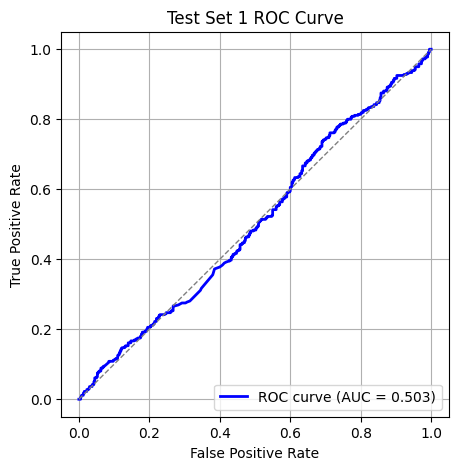

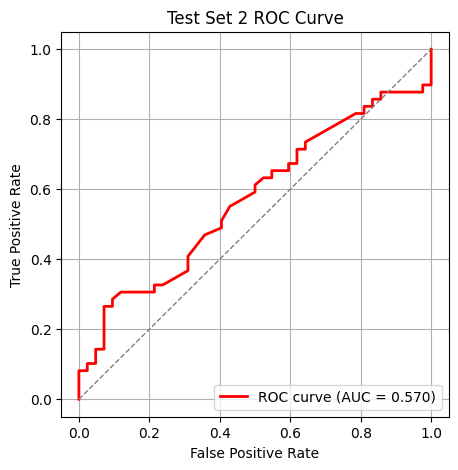

In [18]:
fpr1, tpr1, _ = roc_curve(y_true1, y_score1)
fpr2, tpr2, _ = roc_curve(y_true2, y_score2)

# Test set 1 ROC curve
plt.figure(figsize=(5,5))
plt.plot(fpr1, tpr1, color='blue', lw=2, label='ROC curve (AUC = %.3f)' % test_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set 1 ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Test set 2 ROC curve
plt.figure(figsize=(5,5))
plt.plot(fpr2, tpr2, color='red', lw=2, label='ROC curve (AUC = %.3f)' % test2_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set 2 ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

-----

여기서부터는 사용 안하는 코드입니다.

In [ ]:
class EHR_BERT_LR(nn.Module):
    def __init__(self, input_size,embed_dim, hidden_size, n_layers=1,dropout_r=0.1,cell_type='LSTM',bi=False ,time=False, preTrainEmb=''):
        super(EHR_BERT_LR, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embed_dim = embed_dim
        self.dropout_r = dropout_r
        self.cell_type = cell_type
        self.preTrainEmb=preTrainEmb
        self.time=time

        if bi: self.bi=2
        else: self.bi=1

        self.PreBERTmodel=BertForSequenceClassification.from_pretrained('')
        if use_cuda:
           self.PreBERTmodel.cuda()
        input_size=self.PreBERTmodel.bert.config.vocab_size
        self.in_size= self.PreBERTmodel.bert.config.hidden_size

        self.dropout = nn.Dropout(p=self.dropout_r)
        self.out = nn.Linear(self.in_size,1)
        self.sigmoid = nn.Sigmoid()
        self.softmax=nn.Softmax()
        if use_cuda:
            self.flt_typ=torch.cuda.FloatTensor
            self.lnt_typ=torch.cuda.LongTensor
        else:
            self.lnt_typ=torch.LongTensor
            self.flt_typ=torch.FloatTensor

    def forward(self, sequence):
        token_t=torch.from_numpy(np.asarray(sequence[0],dtype=int)).type(self.lnt_typ)
        seg_t=torch.from_numpy(np.asarray(sequence[2],dtype=int)).type(self.lnt_typ)
        Label_t=torch.from_numpy(np.asarray(sequence[3],dtype=int)).type(self.lnt_typ)
        Bert_out=self.PreBERTmodel.bert(input_ids=token_t, attention_mask=torch.from_numpy(np.asarray(sequence[1],dtype=int)).type(self.lnt_typ),
                                    token_type_ids=seg_t)
        output=self.sigmoid(self.out(Bert_out[1]))
        return output.squeeze(),Label_t.type(self.flt_typ)

In [ ]:
df=pd.DataFrame(results)
df.columns=['Model','Run','Train_size','Test_size','Valid_size','Train_AUC','Valid_AUC','Test_AUC1','Test_AUC2','Best_Epoch']

In [ ]:
df

,Model,Run,Train_size,Test_size,Valid_size,Train_AUC,Valid_AUC,Test_AUC1,Test_AUC2,Best_Epoch
0,Bert only,0,49999,15000,7500,0.894582,0.834894,0.830015,0.827995,2
1,Bert only,1,49999,15000,7500,0.869437,0.832315,0.828231,0.827004,1
2,Bert only,2,49999,15000,7500,0.891686,0.833559,0.829083,0.826013,2
3,Bert only,3,49999,15000,7500,0.895434,0.832507,0.829849,0.826455,2
4,Bert only,4,49999,15000,7500,0.894967,0.832715,0.828891,0.825106,2
5,Bert only,5,49999,15000,7500,0.897067,0.833284,0.827417,0.824605,2
6,Bert only,6,49999,15000,7500,0.891813,0.833898,0.830488,0.829852,2
7,Bert only,7,49999,15000,7500,0.891647,0.835480,0.828714,0.825346,2
8,Bert only,8,49999,15000,7500,0.890096,0.837167,0.830588,0.827677,2
9,Bert only,9,49999,15000,7500,0.872332,0.835150,0.829565,0.825403,1


In [ ]:
#df.to_csv('DHF_RNN_multirun_shuffled_1.csv')

In [ ]:
desc2=df[['Model','Train_size','Test_AUC1']].groupby(['Model','Train_size']).describe()
desc3=df[['Model','Train_size','Test_AUC2']].groupby(['Model','Train_size']).describe()

In [ ]:
desc3

Test_AUC2                                         \
                         count      mean       std       min      25%   
Model     Train_size                                                    
Bert only 49999           10.0  0.826546  0.001613  0.824605  0.82536   

                                                    
                           50%       75%       max  
Model     Train_size                                
Bert only 49999       0.826234  0.827509  0.829852